<a href="https://colab.research.google.com/github/elemi10/7506-TP-Org-de-datos/blob/elemi10-7506-Trabajo-Practico-2/TP_2(2_0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tp-2 Org de datos( FIUBA)


    
      
      
      
***
## Version 2.0
***
### Importacion de librerias

In [ ]:
#IMPORT FILES FROM DRIVE INTO GOOGLE-COLAB:

#STEP-1: Import Libraries

# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
#STEP-2: Autheticate E-Mail ID

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#STEP-3: Get File from Drive using file-ID

#2.1 Get the file
downloaded = drive.CreateFile({'id':'1RAGDjlzJ6spO5Sq8_x3UTIvxLhKAUBEt'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train.csv') 

downloaded1 = drive.CreateFile({'id':'17pAgG9oJRK1bAFWRKkp96__zicG6yUmy'}) # replace the id with id of file you want to access
downloaded1.GetContentFile('test.csv') 

downloaded2 = drive.CreateFile({'id':'1u8v51BT7FZggIRD-eo0dQno--0wlxIhA'}) # replace the id with id of file you want to access
downloaded2.GetContentFile('sample_submission.csv') 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download("popular")
from sklearn import model_selection
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import HashingVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.metrics import f1_score,classification_report
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import re
from nltk.stem import PorterStemmer
from textblob import TextBlob
import xgboost as xgb
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
!pip install bert-tensorflow
import bert

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt


### Archivos necesarios
#### Limpieza del DF

In [ ]:
train=pd.read_csv(r"train.csv")
train.tail()

In [ ]:
test=pd.read_csv(r"test.csv")
test.tail()

In [ ]:
sample_submission=pd.read_csv(r"sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [ ]:
# Categorizamos manualmente las keywords y creamos un archivo xls para despues utilizarlo en nuestro DF original
from google.colab import files
uploaded = files.upload()

Saving df_train_preprocesado.xlsx - categorias_keyword_estadisticas.csv to df_train_preprocesado.xlsx - categorias_keyword_estadisticas.csv


In [ ]:
# solo nos importan determinadas columnas para hacer nuestroa analisis que continua posteriormente
import io
categorias = pd.read_csv(io.BytesIO(uploaded[r'df_train_preprocesado.xlsx - categorias_keyword_estadisticas.csv']),usecols=['keyword','Tipo_Desastre'])

In [ ]:
#DF limpio
categorias=categorias.iloc[:-1,:]

In [ ]:
# Hacemos un merge y agregamos nuevas columnas al DF
train=train.merge(categorias,how='outer',left_on='keyword',right_on='keyword')
test=test.merge(categorias,how='outer',left_on='keyword',right_on='keyword')
train.tail()

,id,keyword,location,text,target,Tipo_Desastre
7608,10830,wrecked,NaN,@jt_ruff23 @cameronhacker and I wrecked you both,0,Accidente/Riesgo
7609,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,Accidente/Riesgo
7610,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,Accidente/Riesgo
7611,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,Accidente/Riesgo
7612,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0,Accidente/Riesgo


In [ ]:
scaler = StandardScaler()
train_fill=train.fillna(value={'keyword':'nokeyword','location':'nolocation'})
test_fill=test.fillna(value={'keyword':'nokeyword','location':'nolocation'})
train_fill['Caracteres']=scaler.fit_transform(np.array(train_fill.text.str.len()).reshape(-1,1))
test_fill['Caracteres']=scaler.transform(np.array(test_fill.text.str.len()).reshape(-1,1))
train_fill.tail()

,id,keyword,location,text,target,Tipo_Desastre,Caracteres
7608,10830,wrecked,nolocation,@jt_ruff23 @cameronhacker and I wrecked you both,0,Accidente/Riesgo,-1.570125
7609,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,Accidente/Riesgo,0.176516
7610,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0,Accidente/Riesgo,-0.237941
7611,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,Accidente/Riesgo,0.087704
7612,10834,wrecked,nolocation,Cramer: Iger's 3 words that wrecked Disney's s...,0,Accidente/Riesgo,-0.622794


In [ ]:
%%time

# Eliminamos links
cleanr = re.compile('https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)')

p=[]
for i in range(len(train_fill)):
    p.append(re.sub(cleanr, '', train_fill['text'].loc[i]))
train_fill['text']=p

t=[]
for i in range(len(train_fill)):
    t.append(re.sub(cleanr, '', train_fill['keyword'].loc[i]))
train_fill['keyword']=t

p1=[]
for i in range(len(test_fill)):
    p1.append(re.sub(cleanr, '', test_fill['text'].loc[i]))
test_fill['text']=p1

t1=[]
for i in range(len(test_fill)):
    t1.append(re.sub(cleanr, '', test_fill['keyword'].loc[i]))
test_fill['keyword']=t1

##### Eliminamos otros posibles links

cleanr1=re.compile('[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)')

p=[]
for i in range(len(train_fill)):
    p.append(re.sub(cleanr1, '', train_fill['text'].loc[i]))
train_fill['text']=p

t=[]
for i in range(len(train_fill)):
    t.append(re.sub(cleanr1, '', train_fill['keyword'].loc[i]))
train_fill['keyword']=t

p1=[]
for i in range(len(test_fill)):
    p1.append(re.sub(cleanr1, '', test_fill['text'].loc[i]))
test_fill['text']=p1

t1=[]
for i in range(len(test_fill)):
    t1.append(re.sub(cleanr1, '', test_fill['keyword'].loc[i]))
test_fill['keyword']=t1


CPU times: user 1.35 s, sys: 0 ns, total: 1.35 s
Wall time: 1.35 s


In [ ]:
%%time
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
st = PorterStemmer()

def clean_text(text):
    text = re.sub(r'(@[A-Za-z0–9]+)|(\w+:\/\/\S+)','',text, re.UNICODE)
    text = re.sub('%20','',text)
    text=' '.join(re.sub('([^0-9A-za-z \t])|(\w+:\/\/\S+)','',text).split())
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    #text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text
# Aplicamos al columnas 
train_fill['text']=train_fill['text'].apply(lambda x: clean_text(x))
test_fill['text']=test_fill['text'].apply(lambda x: clean_text(x))
train_fill['keyword']=train_fill['keyword'].apply(lambda x: clean_text(x))
test_fill['keyword']=test_fill['keyword'].apply(lambda x: clean_text(x))

# Generamos nueva columna que incluya texto y keyword
train_fill['text_keyword']=train_fill.text+' '+train_fill.keyword
test_fill['text_keyword']=test_fill.text+' '+test_fill.keyword
train_fill['t_k_d']=train_fill['text_keyword']+' '+train_fill.Tipo_Desastre
test_fill['t_k+_d']=test_fill['text_keyword']+' '+test_fill.Tipo_Desastre

CPU times: user 3.02 s, sys: 133 ms, total: 3.16 s
Wall time: 3.18 s


In [ ]:
# Eliminamos duplicados
train_fill.drop_duplicates(subset='text_keyword',keep='first',inplace=True)
train_fill.head()

,id,keyword,location,text,target,Tipo_Desastre,Caracteres,text_keyword,t_k_d
0,1,nokeyword,nolocation,our deed be the reason of this earthquake may ...,1,Miscelaneo,-0.948439,our deed be the reason of this earthquake may ...,our deed be the reason of this earthquake may ...
1,4,nokeyword,nolocation,forest fire near la ronge sask canada,1,Miscelaneo,-1.866166,forest fire near la ronge sask canada nokeyword,forest fire near la ronge sask canada nokeywor...
2,5,nokeyword,nolocation,all resident ask to shelter in place be be not...,1,Miscelaneo,0.946223,all resident ask to shelter in place be be not...,all resident ask to shelter in place be be not...
3,6,nokeyword,nolocation,13000 people receive wildfire evacuation order...,1,Miscelaneo,-1.066856,13000 people receive wildfire evacuation order...,13000 people receive wildfire evacuation order...
4,7,nokeyword,nolocation,just get send this photo from ruby alaska a sm...,1,Miscelaneo,-0.385962,just get send this photo from ruby alaska a sm...,just get send this photo from ruby alaska a sm...


## Importamos embeddings y definimos ciertas funciones que se usaran 

In [ ]:
# Importamos Glove
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2020-08-08 01:37:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-08 01:37:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-08 01:37:07--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
## Definimos funcion para crear la matriz con los embeddings
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
### Definimos ciertas metricas para poder tener F1 en keras
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
## Definimos una funcion que nos permita graficar las curvas de aprendizaje
def plot_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(122)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


# Modelos con BOW y ensambles

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(train_fill.text_keyword, train_fill.target, test_size=0.20, random_state=0)

In [ ]:
vectorizer5=CountVectorizer(tokenizer=LemmaTokenizer())
vectorizer5.fit(train_fill.t_k_d)
X_train5=vectorizer5.transform(train_fill.t_k_d)
X_test5=vectorizer5.transform(test_fill.text_keyword)
X_train5

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


<6899x13879 sparse matrix of type '<class 'numpy.int64'>'
	with 98482 stored elements in Compressed Sparse Row format>

In [ ]:
#Modelos y clasificadores
xgb_model=xgb.XGBClassifier(random_state=0)
lr_model=LogisticRegression(random_state=0,solver='liblinear')
cb_model=CatBoostClassifier(random_state=0)
ridge_model=RidgeClassifier(random_state=0)
svr_model=make_pipeline(StandardScaler(with_mean=False),LinearSVC(random_state=0))
knn_model=KNeighborsClassifier()
tree_model=DecisionTreeClassifier(random_state=0)
gbc_model=GradientBoostingClassifier()
mods=[xgb_model,lr_model,cb_model]

In [ ]:
# Creamos un lemmatizador 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# Creamos Lemmatizer para el pipe
class Lemmatizer(BaseEstimator):
    def __init__(self):
        self.l = WordNetLemmatizer()
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        x = map(lambda r:  ' '.join([self.l.lemmatize(i.lower()) for i in r.split()]), x)
        x = np.array(list(x))
        return x

def length_text(x):
    return scaler.fit_transform(np.array(x.str.len()).reshape(-1,1))
lm=Lemmatizer()
vec=CountVectorizer()
pipeline=Pipeline([
    ('features',FeatureUnion([
        ('text',Pipeline([
            ('lm',lm),
            ('vec',vec)])),
            ('lenght',Pipeline([
            ('car',FunctionTransformer(length_text,validate=False))
        ]))
        
    ])),
    ('classifier',lr_model)
])


In [ ]:
def comparacion(X,y,mods=mods):
  a=[]
  for model in mods:
    pipeline.set_params(classifier = model)
    scores=cross_val_score(estimator=pipeline,X=X,y=y,scoring='f1',cv=5)
    a.append(scores)
  return a



In [ ]:
%%time
comparacion(train_fill.text_keyword,train_fill.target,mods)

In [ ]:
vec=HashingVectorizer(tokenizer=LemmaTokenizer())
X_train=vec.fit_transform(train_fill.text_keyword)
X_test=vec.transform(test_fill.text_keyword)
y=train_fill.target
a=cross_val_score(estimator=lr_model,X=X_train,y=train_fill.target,scoring='f1',cv=5)
X_train

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


<6899x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 91594 stored elements in Compressed Sparse Row format>

In [ ]:
c=cross_val_score(estimator=pipeline,X=train_fill.t_k_d,y=train_fill.target,scoring='f1',cv=7)
d=cross_val_score(estimator=pipeline,X=train_fill.text_keyword,y=train_fill.target,scoring='f1',cv=7)
c

array([0.59426848, 0.51162791, 0.46135266, 0.61050328, 0.52899576,
       0.6251768 , 0.68218859])

In [ ]:
lr_model.fit(x_train,y_train)
prediccion=lr_model.predict(x_test)
skere=f1_score(y_test,prediccion)

In [ ]:
estimators=[('GBC',gbc_model),
           ('RIDGE',ridge_model),
            ('lr',lr_model),
            ('tree',tree_model),
            ('knn',knn_model),]
cfl=StackingClassifier(estimators=estimators,final_estimator=lr_model)

In [ ]:
%%time
cross_val_score(estimator=cfl,X=X_train,y=train_fill.target,scoring='f1',cv=5)

CPU times: user 3min 7s, sys: 5.29 s, total: 3min 12s
Wall time: 3min 6s


array([0.572697  , 0.5       , 0.60255319, 0.50863061, 0.62523901])

In [ ]:
cfl.fit(X_train,y=train_fill.target)
stack_prediction=cfl.predict(X_test)
stack_prediction

In [ ]:
sample_submission['target']=stack_prediction
from google.colab import files
sample_submission.to_csv("sub_18.csv",index=False)
files.download('sub_18.csv')

In [ ]:
def get_models():
  models = dict()
  models['lr'] = LogisticRegression(solver='liblinear')
  models['knn']=knn_model
  return models
models=get_models()

In [ ]:
def evaluate_model(model):
	cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=3, random_state=0)
	scores = cross_val_score(model, X_train, y, scoring='f1', cv=cv, n_jobs=1, error_score='raise')
	return scores

In [ ]:
%%time
names=[]
for name, model in models.items():
	scores = evaluate_model(model)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>lr 0.720 (0.020)
>knn 0.657 (0.017)
CPU times: user 21.7 s, sys: 6.32 s, total: 28 s
Wall time: 16.3 s


In [ ]:
prueba=

In [ ]:
!pip install bert-serving-server  # server
!pip install bert-serving-client  # client, independent of `bert-serving-server`

In [ ]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip -q uncased_L-12_H-768_A-12.zip

--2020-08-06 04:08:56--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.1’

uncased_L-12_H-768_ 100%[===================>] 388.84M  80.6MB/s    in 6.7s    

2020-08-06 04:09:03 (58.4 MB/s) - ‘uncased_L-12_H-768_A-12.zip.1’ saved [407727028/407727028]

replace uncased_L-12_H-768_A-12/bert_model.ckpt.meta? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
y
replace uncased_L-12_H-768_A-12/vocab.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace uncased_L-12_H-768_A-12/bert_model.ckpt.index? [y]es, [n]o, [A]ll, [N]one, [r]en

In [ ]:
!nohup bert-serving-start -model_dir=./uncased_L-12_H-768_A-12 > out.file 2>&1 &

In [ ]:
from bert_serving.client import BertClient
bc = BertClient()

KeyboardInterrupt: ignored

## Embeddings

In [ ]:
# Para solo el dataset spliteado
token=Tokenizer(num_words=10000)
token.fit_on_texts(x_train)
# fiteamos
X_emb_train=token.texts_to_sequences(x_train)
X_emb_test=token.texts_to_sequences(x_test)
vocab_size=len(token.word_index)+1
# Padeamos
maxlen=100
X_emb_train=pad_sequences(X_emb_train,padding='post',maxlen=maxlen)
X_emb_test=pad_sequences(X_emb_test,padding='post',maxlen=maxlen)
# Creamos la matriz
emb_matrix=create_embedding_matrix('glove.6B.100d.txt',token.word_index,maxlen)

In [ ]:
# Para todo el dataset
token_g=Tokenizer(num_words=10000)
token_g.fit_on_texts(train_fill.text_keyword)
# fiteamos
X_emb_train_g=token_g.texts_to_sequences(train_fill.text_keyword)
X_emb_test_g=token_g.texts_to_sequences(test_fill.text_keyword)
vocab_size_g=len(token_g.word_index)+1
# Padeamos
maxlen=100
X_emb_train_g=pad_sequences(X_emb_train_g,padding='post',maxlen=maxlen)
X_emb_test_g=pad_sequences(X_emb_test_g,padding='post',maxlen=maxlen)
# Creamos la matriz
emb_matrix_g=create_embedding_matrix('glove.6B.100d.txt',token_g.word_index,maxlen)

### Modelo 0

In [ ]:
model0 = Sequential()

model0.add(layers.Embedding(vocab_size,100, weights=[emb_matrix], input_length=maxlen , trainable=False))

model0.add(layers.GlobalAveragePooling1D())
model0.add(layers.Dense(2,activation='relu'))
model0.add(layers.Dense(1, activation='sigmoid'))

model0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m])

model0.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1185400   
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 1,185,605
Trainable params: 205
Non-trainable params: 1,185,400
_________________________________________________________________


In [ ]:
%%time
history0 = model0.fit(X_emb_train, y_train, batch_size=128, epochs=100, verbose=2, validation_split=0.2)

In [ ]:
score0= model0.evaluate(X_emb_test, y_test, verbose=2)

44/44 - 0s - loss: 0.4810 - accuracy: 0.7804 - f1_m: 0.7137


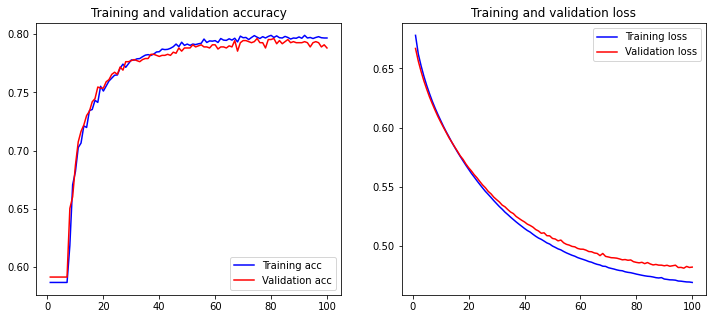

In [ ]:
plot_history(history0)

### Modelo 1

In [ ]:
model1 = Sequential()

model1.add(layers.Embedding(vocab_size,100, weights=[emb_matrix], input_length=maxlen , trainable=False))

model1.add(layers.Flatten())
model1.add(layers.Dense(2,activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m])

model1.summary()

In [ ]:
%%time
history1 = model1.fit(X_emb_train, y_train, batch_size=128, epochs=50, verbose=2, validation_split=0.2)

In [ ]:
score1= model1.evaluate(X_emb_test, y_test, verbose=2)

In [ ]:
plot_history(history1)

### Modelo 2

In [ ]:
model2 = Sequential()

model2.add(layers.Embedding(vocab_size,100, weights=[emb_matrix], input_length=maxlen , trainable=False,mask_zero=True ))
model2.add(layers.Conv1D(128, 5, activation='relu'))
model2.add(layers.GlobalMaxPooling1D())
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m])

model2.summary()

In [ ]:
%%time
history2 = model2.fit(X_emb_train, y_train, batch_size=128, epochs=6, verbose=2, validation_split=0.2)

Epoch 1/6
35/35 - 3s - loss: 0.5395 - accuracy: 0.7241 - f1_m: 0.6380 - val_loss: 0.4782 - val_accuracy: 0.7889 - val_f1_m: 0.7303
Epoch 2/6
35/35 - 3s - loss: 0.4171 - accuracy: 0.8188 - f1_m: 0.7687 - val_loss: 0.4708 - val_accuracy: 0.7962 - val_f1_m: 0.7091
Epoch 3/6
35/35 - 3s - loss: 0.3628 - accuracy: 0.8523 - f1_m: 0.8112 - val_loss: 0.4501 - val_accuracy: 0.8071 - val_f1_m: 0.7414
Epoch 4/6
35/35 - 3s - loss: 0.3150 - accuracy: 0.8849 - f1_m: 0.8514 - val_loss: 0.4595 - val_accuracy: 0.7871 - val_f1_m: 0.7408
Epoch 5/6
35/35 - 3s - loss: 0.2755 - accuracy: 0.9092 - f1_m: 0.8842 - val_loss: 0.4527 - val_accuracy: 0.7926 - val_f1_m: 0.7425
Epoch 6/6
35/35 - 3s - loss: 0.2412 - accuracy: 0.9307 - f1_m: 0.9108 - val_loss: 0.4476 - val_accuracy: 0.8125 - val_f1_m: 0.7502
CPU times: user 34 s, sys: 379 ms, total: 34.4 s
Wall time: 18.3 s


In [ ]:
score2= model2.evaluate(X_emb_test, y_test, verbose=2)

44/44 - 0s - loss: 0.4749 - accuracy: 0.7891 - f1_m: 0.7114


In [ ]:
plot_history(history2)

In [ ]:
## Generalizacion del modelo 2
model2_g = Sequential()

model2_g.add(layers.Embedding(vocab_size_g,100, weights=[emb_matrix_g], input_length=maxlen , trainable=False,mask_zero=True ))
model2_g.add(layers.Conv1D(64, 5, activation='relu'))
model2_g.add(layers.GlobalMaxPooling1D())
model2_g.add(layers.Dense(1, activation='sigmoid'))

model2_g.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m])

model2_g.summary()

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_59 (Embedding)     (None, 100, 100)          1364700   
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 96, 64)            32064     
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 64)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 65        
Total params: 1,396,829
Trainable params: 32,129
Non-trainable params: 1,364,700
_________________________________________________________________


In [ ]:
%%time
history2_g = model2_g.fit(X_emb_train_g, train_fill.target, batch_size=128, epochs=6, verbose=2, validation_split=0.2)

Epoch 1/6
44/44 - 2s - loss: 0.5966 - accuracy: 0.6809 - f1_m: 0.5510 - val_loss: 0.4989 - val_accuracy: 0.7659 - val_f1_m: 0.6699
Epoch 2/6
44/44 - 2s - loss: 0.4686 - accuracy: 0.7853 - f1_m: 0.7282 - val_loss: 0.4809 - val_accuracy: 0.7804 - val_f1_m: 0.7018
Epoch 3/6
44/44 - 2s - loss: 0.4304 - accuracy: 0.8092 - f1_m: 0.7532 - val_loss: 0.4780 - val_accuracy: 0.7935 - val_f1_m: 0.6883
Epoch 4/6
44/44 - 2s - loss: 0.3942 - accuracy: 0.8328 - f1_m: 0.7833 - val_loss: 0.4646 - val_accuracy: 0.7935 - val_f1_m: 0.7039
Epoch 5/6
44/44 - 2s - loss: 0.3681 - accuracy: 0.8492 - f1_m: 0.8038 - val_loss: 0.4675 - val_accuracy: 0.7920 - val_f1_m: 0.6947
Epoch 6/6
44/44 - 2s - loss: 0.3373 - accuracy: 0.8672 - f1_m: 0.8243 - val_loss: 0.4668 - val_accuracy: 0.7920 - val_f1_m: 0.6885
CPU times: user 26.9 s, sys: 426 ms, total: 27.3 s
Wall time: 14.7 s


In [ ]:
pred2=model2_g.predict(X_emb_test_g)
pred2=np.round(pred2).astype(int)
sample_submission['target']=pred2
from google.colab import files
sample_submission.to_csv("sub_19.csv",index=False)
files.download('sub_19.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plot_history(history2_g)

### Modelo 3

In [ ]:
model3 = Sequential()

model3.add(layers.Embedding(vocab_size,100, weights=[emb_matrix], input_length=maxlen , trainable=False))
model3.add(layers.Conv1D(128, 5, activation='relu'))

model3.add(layers.GlobalAveragePooling1D())

model3.add(layers.Dense(2, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m])

model3.summary()

In [ ]:
%%time
history3 = model3.fit(X_emb_train, y_train, batch_size=128, epochs=80, verbose=2, validation_split=0.2)

In [ ]:
score3= model3.evaluate(X_emb_test, y_test, verbose=2)

44/44 - 0s - loss: 0.4640 - accuracy: 0.7971 - f1_m: 0.7178


In [ ]:
plot_history(history3)

### Modelo 4

In [ ]:
model4 = Sequential()

model4.add(layers.Embedding(vocab_size,100, weights=[emb_matrix], input_length=maxlen , trainable=False))

model4.add(layers.GlobalAveragePooling1D())

model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m])

print(model4.summary())

In [ ]:
%%time
history4 = model4.fit(X_emb_train, y_train, batch_size=128, epochs=80, verbose=2, validation_split=0.2)

In [ ]:
score4= model4.evaluate(X_emb_test, y_test, verbose=2)


In [ ]:
plot_history(history4)

### Modelo 5

In [ ]:
model5 = Sequential()

model5.add(layers.Embedding(vocab_size,100, input_length=maxlen , trainable=False))

model5.add(layers.Bidirectional(layers.LSTM(100)))
model5.add(layers.Dense(10,activation='relu'))
model5.add(layers.Dense(1, activation="sigmoid"))

model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m])

model5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1185400   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 10)                2010      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,348,221
Trainable params: 162,821
Non-trainable params: 1,185,400
_________________________________________________________________


In [ ]:
%%time
history5 = model5.fit(X_emb_train, y_train, batch_size=128, epochs=10, verbose=2, validation_split=0.2)

Epoch 1/10
35/35 - 15s - loss: 0.6764 - accuracy: 0.5869 - f1_m: 0.0000e+00 - val_loss: 0.6733 - val_accuracy: 0.5915 - val_f1_m: 0.0000e+00
Epoch 2/10
35/35 - 14s - loss: 0.6663 - accuracy: 0.5869 - f1_m: 0.0000e+00 - val_loss: 0.6634 - val_accuracy: 0.5915 - val_f1_m: 0.0000e+00
Epoch 3/10
35/35 - 14s - loss: 0.6526 - accuracy: 0.6025 - f1_m: 0.1198 - val_loss: 0.6398 - val_accuracy: 0.6368 - val_f1_m: 0.3670
Epoch 4/10
35/35 - 14s - loss: 0.6403 - accuracy: 0.6433 - f1_m: 0.4040 - val_loss: 0.6353 - val_accuracy: 0.6322 - val_f1_m: 0.5129
Epoch 5/10
35/35 - 14s - loss: 0.6312 - accuracy: 0.6430 - f1_m: 0.4453 - val_loss: 0.6229 - val_accuracy: 0.6585 - val_f1_m: 0.4215
Epoch 6/10
35/35 - 14s - loss: 0.6197 - accuracy: 0.6591 - f1_m: 0.5125 - val_loss: 0.6176 - val_accuracy: 0.6486 - val_f1_m: 0.4873
Epoch 7/10
35/35 - 14s - loss: 0.6130 - accuracy: 0.6639 - f1_m: 0.5235 - val_loss: 0.6168 - val_accuracy: 0.6621 - val_f1_m: 0.4522
Epoch 8/10
35/35 - 14s - loss: 0.6070 - accuracy: 0.6

In [ ]:
score5= model5.evaluate(X_emb_test, y_test, verbose=2)


44/44 - 1s - loss: 0.6123 - accuracy: 0.6819 - f1_m: 0.5667


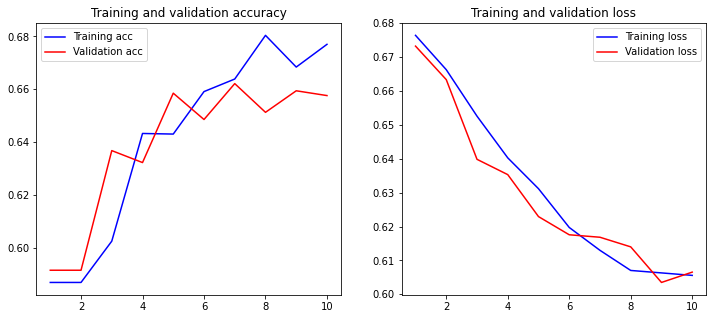

In [ ]:
plot_history(history5)

### Modelo 6

In [ ]:
model6 = Sequential()

model6.add(layers.Embedding(vocab_size,100, input_length=maxlen))

model6.add(layers.GlobalAveragePooling1D())
model6.add(layers.Dense(2,activation='relu'))
model6.add(layers.Dense(1, activation='sigmoid'))

model6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m])

model6.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          1185400   
_________________________________________________________________
global_average_pooling1d_6 ( (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 202       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 3         
Total params: 1,185,605
Trainable params: 1,185,605
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history6 = model6.fit(X_emb_train, y_train, batch_size=64, epochs=25, verbose=2, validation_split=0.2)

In [ ]:
score5= model6.evaluate(X_emb_test, y_test, verbose=2)


44/44 - 0s - loss: 0.5221 - accuracy: 0.7957 - f1_m: 0.7303


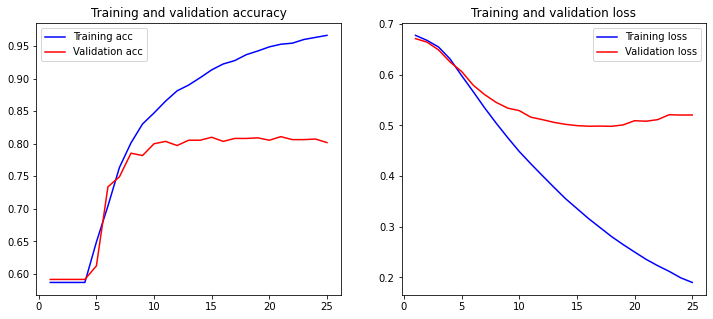

In [ ]:
plot_history(history6)

### Modelo 7

In [ ]:
model7 = Sequential()

model7.add(layers.Embedding(vocab_size,100, input_length=maxlen))
model7.add(layers.Conv1D(filters=32,kernel_size=7,activation='relu'))
model7.add(layers.Dropout(0.2))
model7.add(layers.GlobalAveragePooling1D())
model7.add(layers.Flatten())
model7.add(layers.Dense(10,activation='relu'))
model7.add(layers.Dense(1, activation='sigmoid'))

model7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m])

model7.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 100)          1185400   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 94, 32)            22432     
_________________________________________________________________
dropout_3 (Dropout)          (None, 94, 32)            0         
_________________________________________________________________
global_average_pooling1d_9 ( (None, 32)                0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

In [ ]:
%%time
history7 = model7.fit(X_emb_train, y_train, batch_size=128, epochs=50, verbose=2, validation_split=0.2)

In [ ]:
score7= model7.evaluate(X_emb_test, y_test, verbose=2)


44/44 - 0s - loss: 1.9178 - accuracy: 0.7210 - f1_m: 0.6609


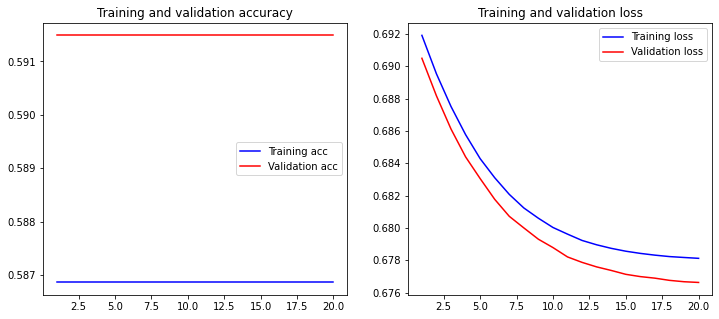

In [ ]:
plot_history(history7)

In [ ]:

def define_model(length, vocab_size):
	# channel 1
	inputs1 = Input(shape=(length,))
	embedding1 = Embedding(vocab_size, 100)(inputs1)
	conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
	drop1 = Dropout(0.5)(conv1)
	pool1 = MaxPooling1D(pool_size=2)(drop1)
	flat1 = Flatten()(pool1)
	# channel 2
	inputs2 = Input(shape=(length,))
	embedding2 = Embedding(vocab_size, 100)(inputs2)
	conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
	drop2 = Dropout(0.5)(conv2)
	pool2 = MaxPooling1D(pool_size=2)(drop2)
	flat2 = Flatten()(pool2)
	# channel 3
	inputs3 = Input(shape=(length,))
	embedding3 = Embedding(vocab_size, 100)(inputs3)
	conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
	drop3 = Dropout(0.5)(conv3)
	pool3 = MaxPooling1D(pool_size=2)(drop3)
	flat3 = Flatten()(pool3)
	# merge
	merged = concatenate([flat1, flat2, flat3])
	# interpretation
	dense1 = Dense(10, activation='relu')(merged)
	outputs = Dense(1, activation='sigmoid')(dense1)
	model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
	# compile
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1_m])
	# summarize
	print(model.summary())
	plot_model(model, show_shapes=True, to_file='multichannel.png')
	return model

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate

In [ ]:
modelito_mlm=define_model(maxlen,vocab_size)

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 100, 100)     1185400     input_13[0][0]                   
_______________________________________________________________________________________

In [ ]:
aver=modelito_mlm.fit([X_emb_train,X_emb_train,X_emb_train],np.array(y_train),epochs=10,batch_size=32,verbose=2,validation_split=0.2)

Epoch 1/10
138/138 - 11s - loss: 0.6733 - accuracy: 0.5846 - f1_m: 0.0026 - val_loss: 0.6037 - val_accuracy: 0.5915 - val_f1_m: 0.0000e+00
Epoch 2/10
138/138 - 10s - loss: 0.5069 - accuracy: 0.7504 - f1_m: 0.5419 - val_loss: 0.4948 - val_accuracy: 0.7899 - val_f1_m: 0.7253
Epoch 3/10
138/138 - 10s - loss: 0.2158 - accuracy: 0.9234 - f1_m: 0.9028 - val_loss: 0.4963 - val_accuracy: 0.7817 - val_f1_m: 0.7214
Epoch 4/10
138/138 - 11s - loss: 0.0806 - accuracy: 0.9730 - f1_m: 0.9662 - val_loss: 0.5295 - val_accuracy: 0.7817 - val_f1_m: 0.7252
Epoch 5/10
138/138 - 11s - loss: 0.0303 - accuracy: 0.9914 - f1_m: 0.9882 - val_loss: 0.6192 - val_accuracy: 0.7708 - val_f1_m: 0.7171
Epoch 6/10
138/138 - 11s - loss: 0.0165 - accuracy: 0.9955 - f1_m: 0.9939 - val_loss: 0.6646 - val_accuracy: 0.7672 - val_f1_m: 0.7121
Epoch 7/10
138/138 - 11s - loss: 0.0096 - accuracy: 0.9971 - f1_m: 0.9961 - val_loss: 0.7120 - val_accuracy: 0.7645 - val_f1_m: 0.7125
Epoch 8/10
138/138 - 11s - loss: 0.0062 - accuracy: